# Softmax Regression (without Scikit-Learn)
This notebook provides a solution to Chapter 4 Exercise 12:
>*Implement Batch Gradient Descent with early stopping for Softmax Regression (without using Scikit-Learn)*

For this task I will use the [IRIS](https://archive.ics.uci.edu/ml/datasets/iris) that is packaged with Scikit-Learn and accessible via the `datasets` module.

In [129]:
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

In [3]:
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [103]:
iris['data'].shape # 150 samples with 4 features

(150, 4)

In [5]:
iris['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In order to allow me to compare my results to those in the corresponding chapter notebook, I will focus on the `petal length (cm)` and `petal_width (cm)` features.

## Data Preparation

In [6]:
feats = ['petal length (cm)', 'petal width (cm)']
feats_idx = [iris['feature_names'].index(ft) for ft in feats]
feats_idx

[2, 3]

In [7]:
X = iris['data'][:,feats_idx]
y = iris['target']

# Need to add x0 = 1 for the bias term - note that the Logistic Regression
# models in Scikit-Learn will automatically add this by default
X_b = np.c_[np.ones((X.shape[0],1)),X]

In [8]:
X_b.shape, y.shape

((150, 3), (150,))

In [9]:
# m  = number of samples
# n = number of features(use X as we dont want to count the bias term)
m, n = X.shape

### Train/Test split

In [10]:
ratio_valid = 0.2
ratio_test = 0.2

valid_count = int(m * ratio_valid)
test_count = int(m * ratio_test)
train_count = m - valid_count - test_count

print(f'Number of training samples: {train_count}')
print(f'Number of validation samples: {valid_count}')
print(f'Number of test samples: {test_count}')

# set random seed to same as exercise solution
np.random.seed(2042)
perms = np.random.permutation(m)

X_train = X_b[perms[:train_count]]
y_train = y[perms[:train_count]]

X_valid = X_b[perms[train_count:train_count + valid_count]]
y_valid = y[perms[train_count:train_count + valid_count]]

X_test = X_b[perms[train_count + valid_count:]]
y_test = y[perms[train_count + valid_count:]]

print(X_train.shape, y_train.shape,
      X_valid.shape, y_valid.shape,
      X_test.shape, y_test.shape,
      sep='\n')

Number of training samples: 90
Number of validation samples: 30
Number of test samples: 30
(90, 3)
(90,)
(30, 3)
(30,)
(30, 3)
(30,)


### Class Probabilities

In [11]:
# For multiclass classifications we need to convert the single target
# class integer into an array of values indictating whether or not
# the sample belongs to each class - 0/1.
# This is similar to One Hot Encoding!
# The result is a 1 x num_classes vector for each record and therefore
# an m x num_classes matrix.

def to_one_hot(y):
    n_classes = y.max() + 1 # only works if the provided y captures all classes
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    
    # indexes are determined pairwise i.e. [sample_1,target_1] = 1
    # therefore this has the effect of, for each sample, setting
    # a value of 1 in the one hot column where the index = target class y
    # e.g.
    # sample_1 = row 0, target_1 = y[0] = 2
    # Y_one_hot[0,2] = 1
    
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [12]:
# Now create the one hot target vectors for the training, validation,
# and test data
y_train_oh = to_one_hot(y_train)
y_valid_oh = to_one_hot(y_valid)
y_test_oh = to_one_hot(y_test)

# Check shapes are as expected
y_train_oh.shape, y_valid_oh.shape, y_test_oh.shape

((90, 3), (30, 3), (30, 3))

## Training the Model

First let's revisit the key functions we need to train the model:

Softmax function:
$\hat{p}_k = \sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

Cross Entropy cost function:
$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

Derivitives wrt. theta:
$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that in the case of this multi class problem, each class has its own weight vector, forming a weight matrix $\mathbf{\Theta}$.

In [75]:
# Write softmax function which outputs the probability that an instance
# belongs to each class.
def softmax(logits):
    exps = np.exp(logits)
    
    # The next step calculates the sums across each column i.e.
    # the sum across the classes per training sample x.
    # Keepdims ensure that the rows dimesion is kept which enables 
    # the subsequent division step, diving each of the elements in
    # each row by the sum of the row.
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    
    return exps / exp_sums

In [77]:
# Determine Theta shape
# The weights of each class are column vectors
num_features = X_train.shape[1] # Bias(x0), x1, x2
num_classes = len(np.unique(y_train)) # number of unique values in the original training labels

print(num_features)
print(num_classes)

3
3


In [154]:
# Train the model!
eta = 0.01 # Learning rate
n_iterations = 5001
m = len(X_train)

# A small value epsilon will be added to the softmax probabilites 
# since a probability of 0 would lead to log(prob) = NaN.
# This way we can avoid NaN values
epsilon = 1e-7 

# No seed set here so Theta will be different each run
Theta = np.random.randn(num_features, num_classes)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta) # aka Softmax Score S(X) 
    y_proba = softmax(logits)
    loss = -np.mean(np.sum(y_train_oh * np.log(y_proba + epsilon), axis=1)) # Cross Entropy
    error = y_proba - y_train_oh # used for Gradients i.e. models probabilities - actual probabilities
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 5.014814575490118
500 0.6811275626429963
1000 0.5968843868029615
1500 0.5410632870346399
2000 0.5009884908986575
2500 0.4704027317886758
3000 0.4459770748939527
3500 0.4258008727380702
4000 0.40870186227996946
4500 0.3939192362234628
5000 0.380935602709643


In [155]:
# Optimum Theta
Theta

array([[ 2.46836275, -1.06170359, -3.68946681],
       [ 0.04314251,  0.70028679,  0.6751566 ],
       [-2.65819996, -0.31828919,  1.45534173]])

## Evaluating the Model

In [158]:
# Predictions
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1) # finds the index of the maxiumum value (probability) in each row

accuracy_score = np.mean(y_predict == y_valid) # simple proportion of correct predictions
accuracy_score

0.9666666666666667

## Adding L2 Regularisation

In [159]:
eta = 0.1 # Also increased learning rate
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

# No seed set here so Theta will be different each run
Theta = np.random.randn(num_features, num_classes)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(y_train_oh * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:])) # bias weights excluded
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - y_train_oh
    if iteration % 500 == 0:
        print(iteration, loss)
    
    # Update the gradient vector by adding alpha * weights - ensuring bias weights
    # i.e. theta row 1 are set to 0
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, num_classes]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 5.058737217923177
500 0.5373256024848877
1000 0.5045948352969146
1500 0.4950337666346724
2000 0.49143507824842264
2500 0.48995772120134584
3000 0.4893245426953957
3500 0.4890464302497133
4000 0.48892243473590447
4500 0.4888666261358315
5000 0.48884135296647085


In [162]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

This shows a greater loss than previously (model is less flexible due to regularisation) but a better ability to generalise (No overfitting training data)!

However, the train/validation sets are relatively small - it could just be luck that the model predicted everything correct on the validation set. Cross validation should provide a better evaluation metric.

## Early Stopping
To implement early stopping we need to evaluate the model at each epoch and stop when the validation metric starts to deteriorate. Here I use the loss.

In [163]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1
best_loss = np.inf

# No seed set here so Theta will be different each run
Theta = np.random.randn(num_features, num_classes)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(y_train_oh * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - y_train_oh
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, num_classes]), alpha * Theta[1:]]
    new_Theta = Theta - eta * gradients # new variable so that the starting Theta is not lost
        
    # Evaluate on validation set
    logits = X_valid.dot(new_Theta) 
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(y_valid_oh * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(new_Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss # regularised loss
    
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
        # Can update Theta with the new_Theta since the loss is now the best
        Theta = new_Theta
    else:
        # Don't update Theta to new_Theta since it has a greater loss and we want to stop
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

0 1.9370173788894922
500 0.5654559400038801
1000 0.5415210310983852
1500 0.5349845306553542
2000 0.5330329815281787
2500 0.5325687260194255
2689 0.5325456297360383
2690 0.5325456300313476 early stopping!


In [164]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba,axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

Model still has the same high accuracy but needed around half the epochs!

## Plot Model Predictions

In [142]:
# For this we want to sample points in the feature space
# i.e. all combinations of x1,x2 (petal_length, petal_width)
min_x1, min_x2 = X.min(axis=0)
max_x1, max_x2 = X.max(axis=0)
print(f'Petal Length: {min_x1} - {max_x1}')
print(f'Petal Width: {min_x2} - {max_x2}')

Petal Length: 1.0 - 6.9
Petal Width: 0.1 - 2.5


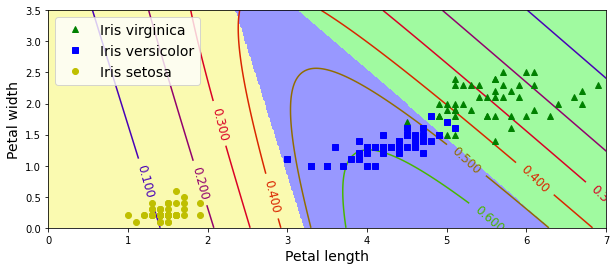

In [165]:
# Meshgrid is used to sample the x1, x2 values over this feature space (and a little bit more)
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1), # 500 points for petal length
        np.linspace(0, 3.5, 200).reshape(-1, 1), # 200 points for petal width
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

# Add the bias term
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape) # probability that the instance is in the Iris Versicolour class
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

## Evaluate on Test Set

In [166]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333

Our perfect model turns out to have slight imperfections. This variability is likely due to the very small size of the dataset: depending on how you sample the training set, validation set and the test set, you can get quite different results. Try changing the random seed and running the code again a few times, you will see that the results will vary.